In [6]:
import torch
from torchvision import transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from deepfool_et import deepfool_et

In [7]:
# Select image and the target label. The target variable stores the index of the label from " synset_words.txt "
im_orig = Image.open( 'images/test_im1.jpg' )
target = 298

In [8]:
net = models.resnet50( pretrained=True )

net.eval()

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

im = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)

r, loop_i, label_orig, label_pert, pert_image, confidence_target, confidence_orig, change, ssim_value = deepfool_et(im, net, target, min_confidence=90)

labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int_(label_orig)].split(',')[0]
str_label_pert = labels[np.int_(label_pert)].split(',')[0]

def clip_tensor(A, minv, maxv):
    A = torch.max(A, minv*torch.ones(A.shape))
    A = torch.min(A, maxv*torch.ones(A.shape))
    return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=list(map(lambda x: 1 / x, std))),
transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1, 1, 1]),
transforms.Lambda(clip),
transforms.ToPILImage(),
transforms.CenterCrop(224)])

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)
print("Source Confidence: {:.2f}%".format(confidence_orig * 100))
print("Target Confidence: {:.2f}%".format(confidence_target * 100))
print("Number of perturbations: {}".format(loop_i))
print("Change in image: {:.2f}%".format(change * 100))
print("SSIM score:", ssim_value)

Using GPU
Original label =  n01855672 goose
Perturbed label =  n02137549 mongoose
Source Confidence: 0.00%
Target Confidence: 98.35%
Number of perturbations: 25
Change in image: 1.62%
SSIM score: 0.993


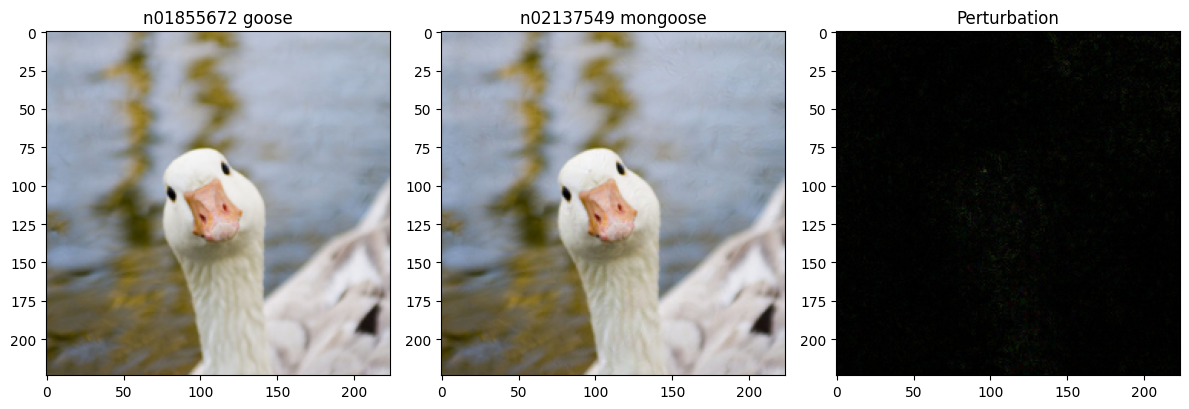

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

im = im.numpy().transpose((1, 2, 0))

im = std * im + mean
im = np.clip(im, 0, 1)

# Display the original image with its label
axs[0].imshow(im)
axs[0].set_title(str_label_orig)
axs[1].imshow(tf(pert_image.cpu()[0]))
axs[1].set_title(str_label_pert)

# Display only the perturbations
r = np.squeeze(r)  
r = np.transpose(r, (1, 2, 0)) 

# Display the perturbed image with its label
axs[2].imshow(np.abs(r))
axs[2].set_title('Perturbation')

plt.tight_layout()
plt.show()